## Compare Sagnac Frequency and Beam Power

## Imports

In [1]:
import os
import matplotlib.pyplot as plt

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Stream, Trace
from numpy import array

from functions.load_sagnac_beat_data import __load_sagnac_beat_data
from functions.smoothing import __smooth

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [201]:
config = {}

config['seed'] = "BW.DROMY..FJZ"

# config['filename'] = "FJZ_powermeter_2"
# config['filename'] = "FJZ_powermeter_20230602"

## new test with good RZ sagnac contrast
# config['filename'] = "FJZ_powermeter_20230602"
config['filename'] = "FJZ_powermeter_20230605"

config['tbeg'] = UTCDateTime("2023-06-05 17:00")
config['tend'] = UTCDateTime("2023-06-05 22:00")

config['datapath'] = data_path+"sagnac_frequency/data/beampower/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

config['data_sagnac'] = data_path+"sagnac_frequency/autodata/2023/RZ/"


## Create PKL and MSEED files

In [58]:
# filename = config['filename']

# ## read data
# df = read_csv(config['datapath']+filename+".csv", header=4, delimiter="\t", names=["power_W", "time_ms"])

# ## write as pickle file
# df.to_pickle(config['datapath']+filename+".pkl")

# ## get start time and convert to UTC
# dt = read_csv(config['datapath']+filename+".csv", nrows=1, delimiter="\t", names=["datetime"]).datetime[0]
# dt = UTCDateTime(dt) - 7200

# ## sampling rate
# delta_t = 300*1e-3 ## seconds

# ## cut some samples at the start with light still on...
# n_samples_to_cut = 4000

# ## create trace object
# tr = Trace()
# tr.data = array(df['power_W'][n_samples_to_cut:])
# tr.stats.starttime = dt+n_samples_to_cut*delta_t
# tr.stats.delta = delta_t

# ## write as stream object
# st = Stream()
# st += tr
# st.write(config['datapath']+filename+".mseed", format="MSEED")
# st.plot();

### Load Sagnac Data

In [75]:
#load data
fjz = __load_sagnac_beat_data(config['tbeg'].date, config['tend']+86400, "Z", path_to_data=archive_path+"romy_autodata/")

# add relative times
fjz['times_rel'] = fjz.times_utc - config['tbeg']

# cut time period
fjz = fjz[(fjz.times_utc > config['tbeg']) & (fjz.times_utc < config['tend'])]

### Load Powermeter Data

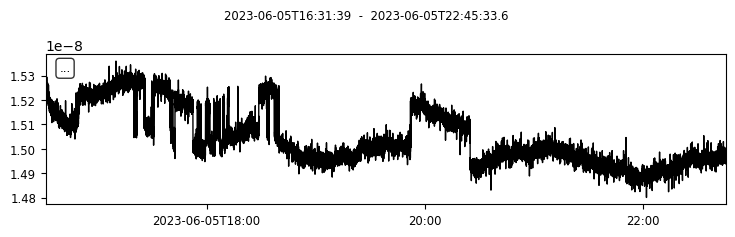

In [76]:
power = read(config['datapath']+config['filename']+"_2.mseed")

power.plot();

In [77]:
# creating dataframe
power_df = DataFrame()

power_df['power_W'] = power[0].data
power_df['times_rel'] = power[0].times(reftime=config['tbeg'])
power_df['power_W_smth'] = __smooth(power[0].data, 200)


## Regression

In [133]:
from functions.regression import __regression

In [162]:
from numpy import interp

power_interp = interp(fjz.times_rel, power_df.times_rel, power_df.power_W_smth)

N = len(power_interp)

df0 = DataFrame()
df0['time'] = fjz.times_rel[-N:]
df0['power'] = power_interp[-N:]
df0['contrast'] = fjz.contrast_z[-N:]
df0['psd_max'] = fjz.pz[-N:]

out_c = __regression(df0, ['contrast'], target='power', reg="ransac")
out_p = __regression(df0, ['psd_max'], target='power', reg="ransac")

R2: 0.4085510268256468
IC:  1.7606471352242109e-09
Coef:  [1.74351955e-08]
contrast : 1.7435195450906485e-08
R2: 0.5430471302143483
IC:  8.629453673533448e-09
Coef:  [2.0569763e-08]
psd_max : 2.056976303875215e-08


## Plot Power

In [199]:
def __makeplot_beampower():

    fig, ax = plt.subplots(2,1, figsize=(15,7), sharex=True)

    plt.subplots_adjust(hspace=0.05)

    font = 14
    
    tscale = 1/3600

    pscale = 1e9

    smooting = 10
    
    cut_off = int(smooting/2)

    ax[0].scatter(fjz['times_rel']*tscale, fjz.fj, c="black", s=12, alpha=0.4, zorder=2)
    ax[0].plot(fjz['times_rel']*tscale, fjz.fj, c="black", alpha=0.9, zorder=2, label="FJZ")

    ax[1].plot(power_df['times_rel']*tscale, power_df['power_W']*pscale, c="tab:orange", alpha=1, zorder=2)
    ax[1].plot(power_df['times_rel']*tscale, power_df['power_W_smth']*pscale, c="black", alpha=1, zorder=2)

    ax1_2= ax[1].twinx()
    ax1_2.scatter(fjz['times_rel']*tscale, fjz['pz'], c="tab:blue", alpha=0.9, zorder=2, s=5, label="FJZ")
    ax1_2.tick_params(axis="y", colors="tab:blue")

    ax1_3= ax[1].twinx()
    ax1_3.scatter(fjz['times_rel']*tscale, fjz['contrast_z'], c="tab:green", alpha=0.8, zorder=2, s=5, label="FJZ")
    ax1_3.tick_params(axis="y", colors="tab:green")
    ax1_3.spines['right'].set_position(('axes', 1.1))
    ax1_3.set_ylabel("contrast", color="tab:green", fontsize=font)

    ax[0].set_ylabel(r"$\delta$f (Hz)", fontsize=font)
    ax[1].set_ylabel(r"Beam Power (nW)", fontsize=font)
    ax1_2.set_ylabel(r"PSD$_{max} (V^2/Hz)$", fontsize=font, color="#3776ab")

    ax[1].set_xlabel(f"Time (hour) since {str(config['tbeg'].time)} UTC", fontsize=font)

    ax[0].legend(loc=4)

    ax[0].ticklabel_format(useOffset=False, style='plain')
    ax[1].ticklabel_format(useOffset=False, style='plain')

    ax[0].tick_params(labelsize=font-2)
    ax[1].tick_params(labelsize=font-2)
    ax1_2.tick_params(labelsize=font-2)
    ax1_3.tick_params(labelsize=font-2)

    ax[0].set_title(f"ROMY RZ on {config['tbeg'].date}", fontsize=font+1)
    
    ax[0].set_xlim(0, (config['tend']-config['tbeg'])*tscale)
    ax[1].set_xlim(0, (config['tend']-config['tbeg'])*tscale)

    for _k, ll in enumerate(['(a)','(b)']):
        ax[_k].text(0.005, 0.97, ll, ha="left", va="top", transform=ax[_k].transAxes, fontsize=font+1)

    u = r"V$^{-2}$"
    l1 = f"{out_p['inter']*pscale:.2f} nW + {out_p['slope'][0]*pscale:.2f} nW{u}Hz x PSD"
    ax[1].text(0.97, 0.97, l1, ha="right", va="top", transform=ax[1].transAxes, fontsize=font-1)

    l1 = f"{out_c['inter']*pscale:.2f} nW + {out_c['slope'][0]*pscale:.2f} nW x Contrast"
    ax[1].text(0.97, 0.87, l1, ha="right", va="top", transform=ax[1].transAxes, fontsize=font-1)

    plt.show();
    return fig

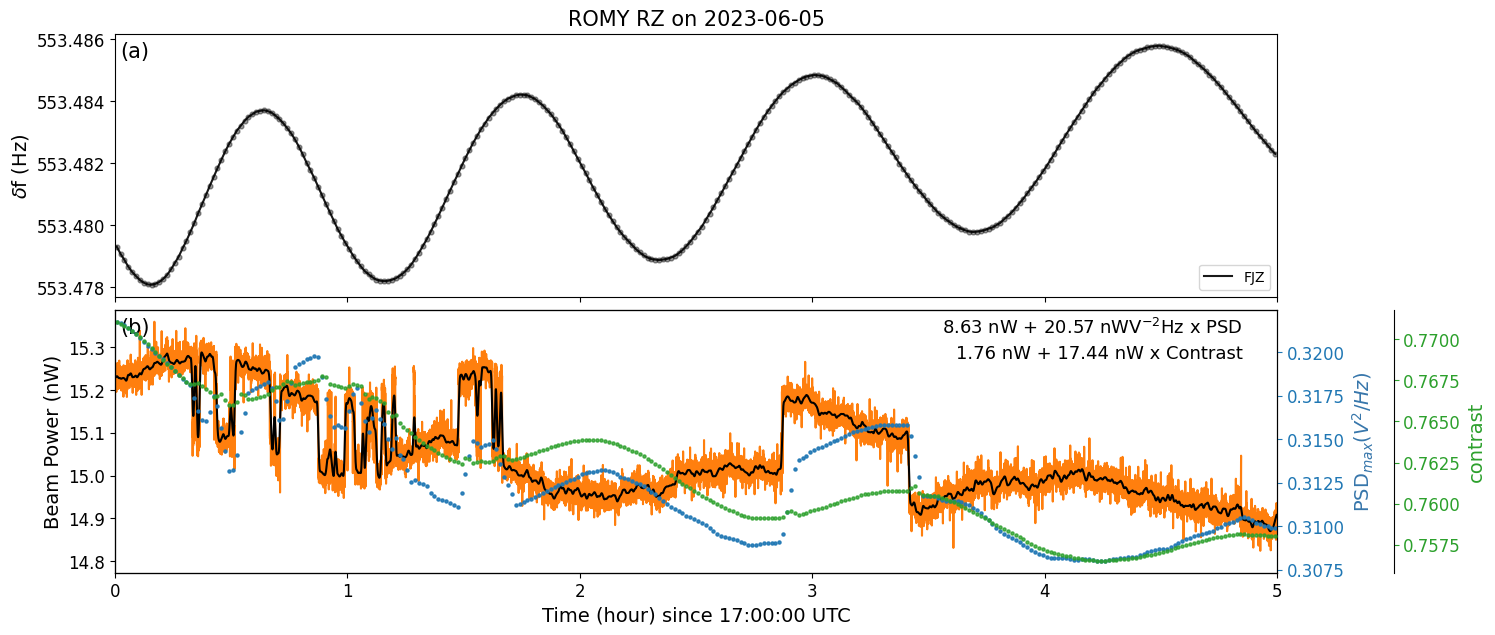

In [202]:
fig = __makeplot_beampower()

fig.savefig(config['path_to_figs']+f"SF_beampower_{config['tbeg'].date}.png", format="png", dpi=150, bbox_inches='tight')


Text(0, 0.5, 'PSD_{max} ()')

Text(0.5, 0, 'Beam Power (nW)')

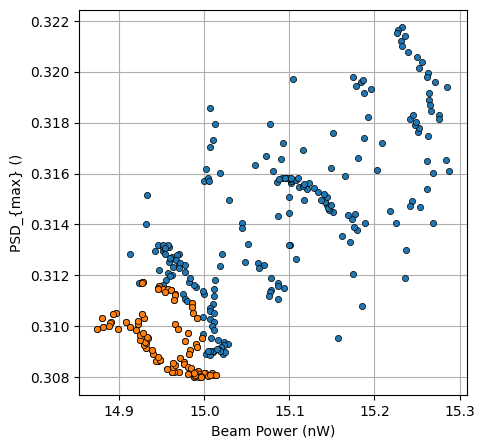

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(power_interp*1e9, fjz.pz, s=20, zorder=2, edgecolors="k", lw=0.5)
ax.scatter(power_interp[-90:]*1e9, fjz.pz[-90:], s=20, zorder=2, edgecolors="k", lw=0.5)

ax.set_ylabel("PSD_{max} ()")
ax.set_xlabel("Beam Power (nW)")

# ax.set_ylim(0.305, 0.325)
ax.grid(zorder=0)

Text(0, 0.5, 'Contrast')

Text(0.5, 0, 'Beam Power (nW)')

(0.75, 0.775)

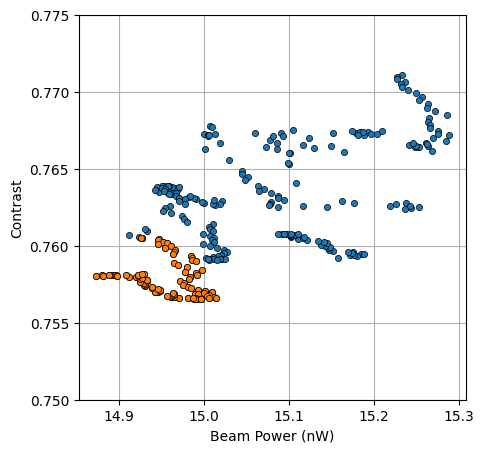

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(power_interp*1e9, fjz.contrast_z, s=20, zorder=2, edgecolors="k", lw=0.5)
ax.scatter(power_interp[-90:]*1e9, fjz.contrast_z[-90:], s=20, zorder=2, edgecolors="k", lw=0.5)

ax.set_ylabel("Contrast")
ax.set_xlabel("Beam Power (nW)")

ax.set_ylim(0.75, 0.775)
ax.grid(zorder=0)

## Plot Power two dataset joint

error for /import/kilauea-data/sagnac_frequency/autodata/2023/RZ/FJZ_20230605.pkl


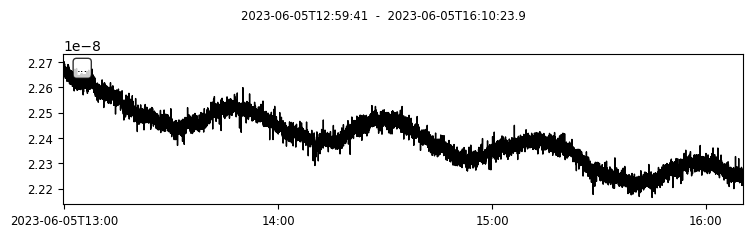

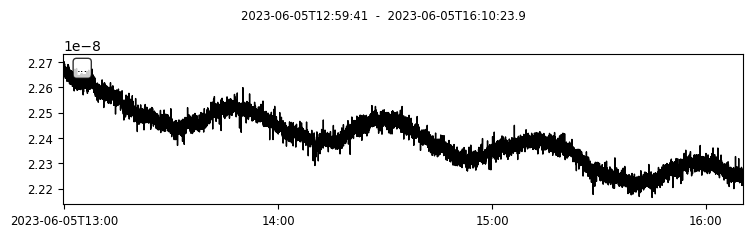

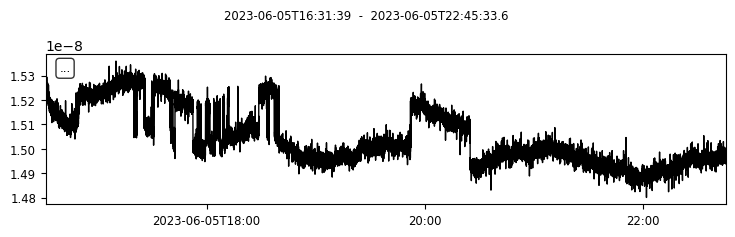

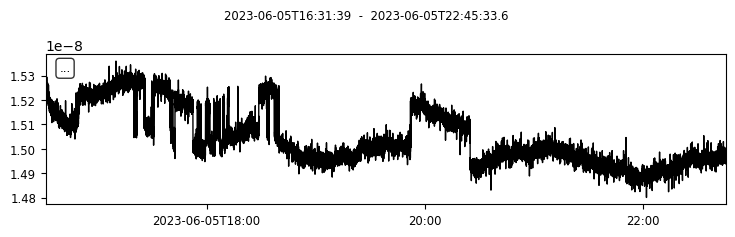

AttributeError: 'DataFrame' object has no attribute 'times_mjd'

In [15]:
config['seed'] = "BW.DROMY..FJZ"
fjz = __load_data(config)

power1 = read(config['datapath']+config['filename']+"_1.mseed")
power1.plot();

power2 = read(config['datapath']+config['filename']+"_2.mseed")
power2.plot();

from andbro__utc_to_mjd import __utc_to_mjd

times_mjd_1 = __utc_to_mjd(list(power1[0].times("utcdatetime")))
times_mjd_2 = __utc_to_mjd(list(power2[0].times("utcdatetime")))

## creating dataframe
power1_df = DataFrame()

power1_df['power_W'] = power1[0].data
power1_df['times_mjd'] = times_mjd_1

## creating dataframe
power2_df = DataFrame()

power2_df['power_W'] = power2[0].data
power2_df['times_mjd'] = times_mjd_2

fjz = fjz[(fjz.times_mjd >= power1_df.times_mjd[0]) & (fjz.times_mjd <= power2_df.times_mjd[len(power2_df.times_mjd)-1])]

In [ ]:
def __makeplot_beampower2(df1, df2, df3):

    def __smooth(y, box_pts):
        from numpy import ones, convolve, hanning

    #         win = ones(box_pts)/box_pts
        win = hanning(box_pts)
        y_smooth = convolve(y, win/sum(win), mode='same')

        return y_smooth

    
    ## ___________________
    ##
    
    fig, ax = plt.subplots(2,1, figsize=(15,7), sharex=True)
    
    plt.subplots_adjust(hspace=0.05)
    
    font = 14
    smooting = 10
    cut_off = int(smooting/2)
    
    ## DF1
#     ax[0].scatter(df1['times_mjd'], df1['fz'], c="black", s=12, alpha=0.4, zorder=2)
    ax[0].plot(df1['times_mjd'], df1['fz'], c="black", alpha=0.8, zorder=2, label="FJZ")
    
    
    ## DF2
    ax[1].plot(df2['times_mjd'], df2['power_W']*1e9, c="#f48512", alpha=0.8, zorder=2)
    ax[1].plot(df3['times_mjd'], df3['power_W']*1e9, c="#f48512", alpha=0.8, zorder=2)

    
    ax1_2= ax[1].twinx()
    ax1_2.plot(df1['times_mjd'], df1['pz'], c="tab:blue", alpha=0.8, zorder=2, label="FJZ")
    ax1_2.tick_params(axis="y", colors="tab:blue")
    
    ax1_3= ax[1].twinx()
    ax1_3.plot(df1['times_mjd'], df1['contrast_z'], c="tab:green", alpha=0.8, zorder=2, label="FJZ")
    ax1_3.tick_params(axis="y", colors="tab:green")
    

#     ax[0].set_yscale("log")
#     ax[1].set_yscale("log")
    
    ax[0].set_ylabel(r"Beat Note (Hz)", fontsize=font)
    ax[1].set_ylabel(r"Power (nW)", fontsize=font)
    ax1_2.set_ylabel(r"PSD$_{max} (V^2/Hz)$", fontsize=font, color="#3776ab")

    ax[1].set_xlabel("Days (MJD)", fontsize=font)
    
    ax[0].legend(loc=4)
    
    ax[0].ticklabel_format(useOffset=False, style='plain')
    ax[1].ticklabel_format(useOffset=False, style='plain')
           
    for i in range(2):
        ax[i].grid(zorder=0)
    
    plt.show();

In [ ]:
__makeplot_beampower2(fjz, power1_df, power2_df)